### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [3]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F # Contiene una versione funzionale di molti layer. 
import torchvision.transforms as transforms
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

In [24]:
# Hyperparameters
eval_percentage = 0.3
lr = 0.0001
opt = 'Adam'
loss = 'CrossEntropy'
epochs = 50
layers = [28*28, 64, 64, 10]
batch_size = 64



In [5]:
# Data import
def import_MNIST():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Numeri per fare la standardizzazione di MNIST si ottengono come sotto
    ])
    
    
    
    train_data = MNIST(root='./data', train=True, download=True, transform=transform)
    eval_size = round(eval_percentage*(len(train_data)))
    eval_data = Subset(train_data, range(eval_size))
    train_data = Subset(train_data, range(eval_size, len(train_data)))
    test_data = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
    evaluation   = torch.utils.data.DataLoader(eval_data, batch_size, num_workers=4)
    test  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=4)

    
    return train, evaluation, test

In [14]:
class simpleMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)

In [15]:
model1 = simpleMLP(layers)
print(model1)

simpleMLP(
  (layers): Sequential(
    (layer-flatten): Flatten(start_dim=1, end_dim=-1)
    (layer-0): Linear(in_features=784, out_features=64, bias=True)
    (Nonlinearity-layer-0): ReLU()
    (layer-1): Linear(in_features=64, out_features=64, bias=True)
    (Nonlinearity-layer-1): ReLU()
    (layer-2): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Riscrivere evaluate e plot

In [16]:
# Function to evaluate model over all samples in the data loader.
def evaluate(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = [] 
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.cpu().numpy()) # detach() si usa per staccare il tensore dal grafo del calcolo .cpu() si usa per spostare il tensore dalla gpu alla cpu
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

In [17]:
def train_batch(epoch, model, optimizer, loss_fn, train_data, device):
    losses = []
    for (value, label) in tqdm(train_data, desc=f'Training epoch {epoch}', leave=True):
        value = value.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        prediction = model(value)
        
        # Choose loss function
        if loss == 'CrossEntropy':
            loss_fn = nn.CrossEntropyLoss()
            
        loss_value = loss_fn(prediction, label)
        loss_value.backward()
        optimizer.step()
        losses.append(loss_value.item())
    return np.mean(losses)

def train_model(model, optimizer, loss, epochs, train_data, eval_data, device):
    model.train()
    losses_and_accs = []
    for epoch in range(epochs):
        loss_value = train_batch(epoch, model, optimizer, loss, train_data, device)
        (accuracy, _) = evaluate(model, eval_data, device)
        losses_and_accs.append((loss_value, accuracy))
        #losses_and_accs.append(loss_value)
    return losses_and_accs

            

In [25]:
# Main function
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()

# Instance of the model
model = simpleMLP(layers)
model.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses_and_accs = train_model(model, optimizer, loss, epochs, train_data, eval_data, device)



Training epoch 49: 100%|███████████████████████████████████████████| 657/657 [00:03<00:00, 203.93it/s]
                                                                                                      

0.023044912680193975


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.972     0.989     0.980       980
           1      0.985     0.988     0.986      1135
           2      0.968     0.970     0.969      1032
           3      0.950     0.973     0.961      1010
           4      0.973     0.967     0.970       982
           5      0.972     0.963     0.967       892
           6      0.979     0.980     0.980       958
           7      0.975     0.970     0.972      1028
           8      0.970     0.957     0.963       974
           9      0.968     0.952     0.960      1009

    accuracy                          0.971     10000
   macro avg      0.971     0.971     0.971     10000
weighted avg      0.971     0.971     0.971     10000



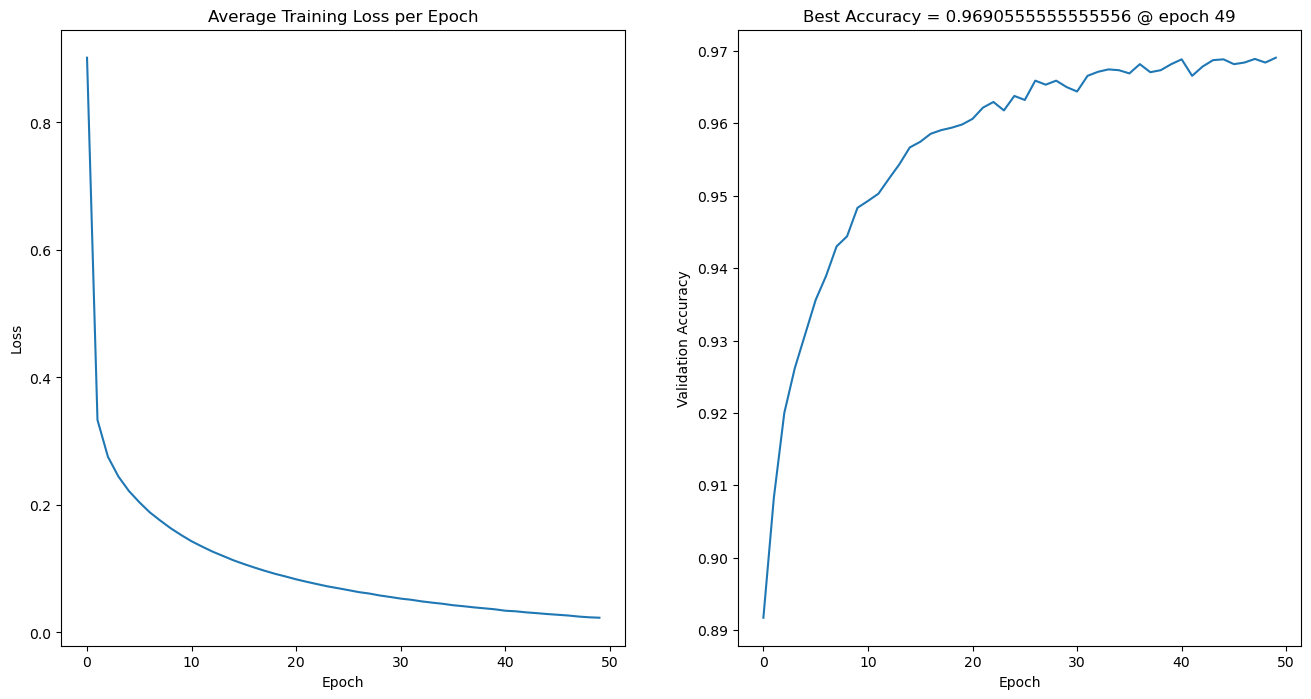

In [26]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [35]:
layersres = [28*28, 64, 128, 256, 64, 32, 10]
class skipMLPBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, out_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(out_size, out_size)

    def forward(self, x):
        out1 = self.layer1(x)
        out1_relu = self.relu1(out1)
        out2 = self.layer2(out1_relu)

        out = x + out2
            
        return out

class skipMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer-{i}', skipMLPBlock(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                    self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)

modelres = resMLP(layersres)
print(modelres)

resMLP(
  (layers): Sequential(
    (layer-flatten): Flatten(start_dim=1, end_dim=-1)
    (layer-0): Linear(in_features=784, out_features=64, bias=True)
    (Nonlinearity-layer-0): ReLU()
    (layer-1): Linear(in_features=64, out_features=128, bias=True)
    (layer-2): Linear(in_features=128, out_features=256, bias=True)
    (Nonlinearity-layer-2): ReLU()
    (layer-3): Linear(in_features=256, out_features=64, bias=True)
    (layer-4): Linear(in_features=64, out_features=32, bias=True)
    (Nonlinearity-layer-4): ReLU()
    (layer-5): Linear(in_features=32, out_features=10, bias=True)
  )
)


### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [36]:
# Main function 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()

# Instance of the model
modelskip = skipMLP(layers)
modelskip.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses_and_accs = train_model(model, optimizer, loss, epochs, train_data, eval_data, device)

Training epoch 49: 100%|███████████████████████████████████| 657/657 [00:03<00:00, 216.58it/s]
                                                                                              

0.0013212768701602396


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.972     0.990     0.981       980
           1      0.982     0.988     0.985      1135
           2      0.967     0.959     0.963      1032
           3      0.966     0.969     0.968      1010
           4      0.966     0.973     0.969       982
           5      0.971     0.970     0.970       892
           6      0.977     0.981     0.979       958
           7      0.976     0.965     0.971      1028
           8      0.966     0.964     0.965       974
           9      0.968     0.952     0.960      1009

    accuracy                          0.971     10000
   macro avg      0.971     0.971     0.971     10000
weighted avg      0.971     0.971     0.971     10000



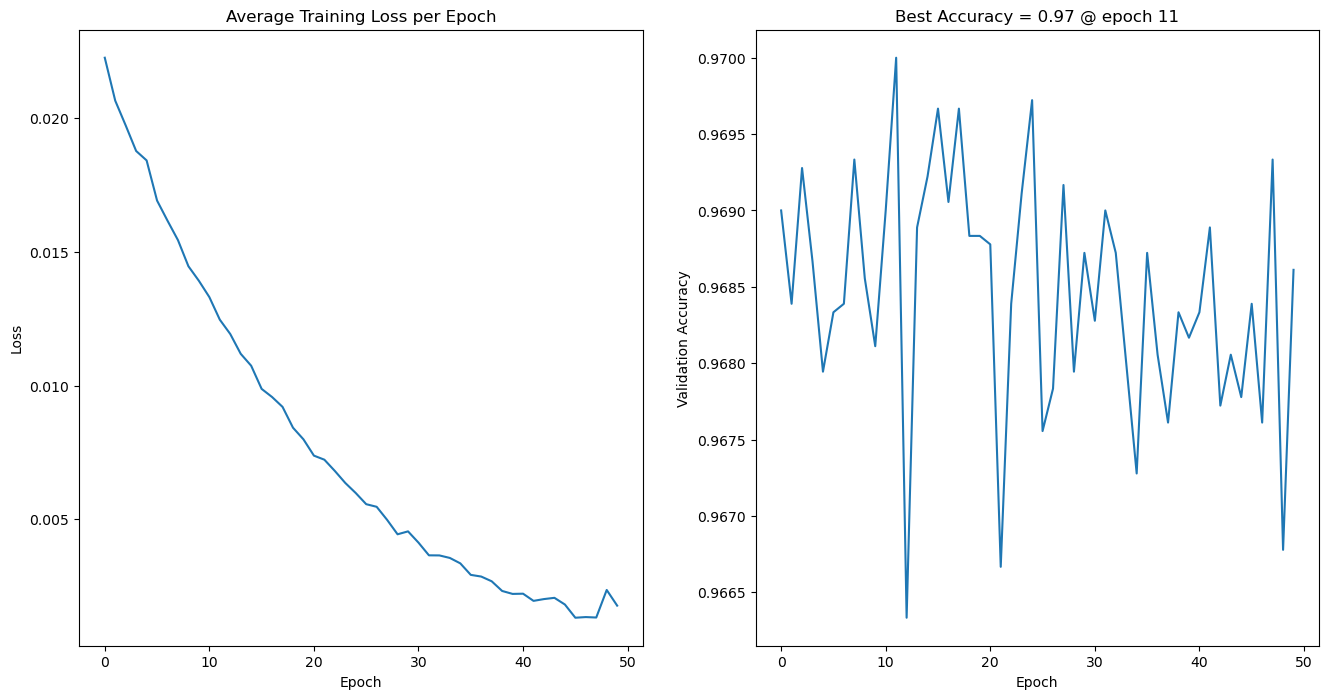

In [37]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')